In [1]:
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

## 1. Generate Data

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })

y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)

true sigma2_star is 0.04453815471624844
true v_j list is [0.02279706 0.03325836 0.02826783 0.04070575]


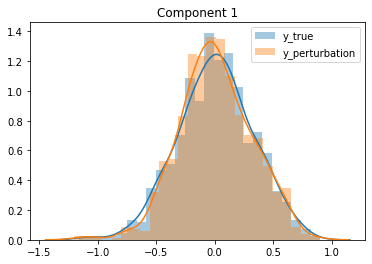

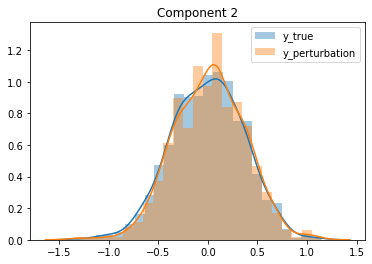

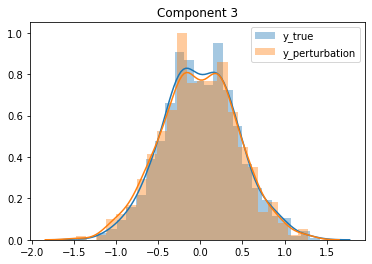

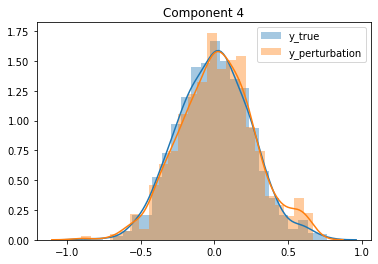

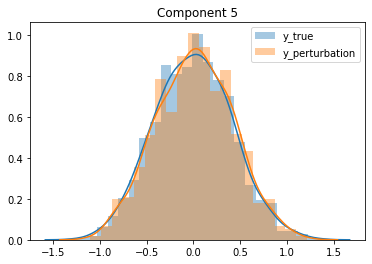

In [4]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_perturbation[j,:], label='y_perturbation')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    
X = y_true

## 2. MCMC Prior and Starting Point


In [5]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [6]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


In [7]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

In [27]:
sm = pystan.StanModel(model_code = ppca_code) # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_488c62c75754230b27e958be99d1948c NOW.


In [28]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
        'v': 1/np.random.gamma(a_vj, 1/ beta_vj),
        'sigma2': 1/np.random.gamma(a_sigma2, 1/beta_sigma2),
        "W": np.random.normal(0, 1, [q, d])
    }
    init_list.append(temp_dict)

In [29]:
init_list=[]
for i_ in range(n_chains):
    temp_dict={
        #'v': np.repeat(v_star_list, q).ravel(),
#        'v': sorted(v_star_list),
        'v': sorted(1/np.random.gamma(a_vj, 1/ beta_vj)),
        'sigma2': sigma2_star,
        "W": W_star.T
    }
    init_list.append(temp_dict)

## 3. MCMC Standard

In [30]:
print(sm.model_code)


data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
//    matrix[N,D] x; // data
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
    real epsilon;// w_j mean
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
 //   vector[Q] v; // true v_j
}

transformed data {
    matrix[D,D] S;
    S = x[1] * x[1]';
    
    for (n in 2:N){
    S += x[n] * x[n]';
    }
    S = S/N;
    
}
parameters {
    vector[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    
    C = crossprod(W)+ sigma2 * diag_matrix(rep_vector(1, D));
    

    target += - xi * N/2 *(log_determin

In [31]:
ppca_dat_standard = {'D': d,
            'N': n_sample,
            'Q': q,
            'x': X.reshape([n_sample, d]),
            'xi': 1,
            'a_vj': a_vj[0],
            'epsilon': epsilon,
            'a_sigma2': a_sigma2,
            'beta_sigma2': beta_sigma2
                           }


In [32]:
fit_standard = sm.sampling(data = ppca_dat_standard, iter = iterations, chains = n_chains, init = init_list, seed =1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Posterior Predictive Check

In [33]:
y_hat = fit_standard.extract('y_hat')['y_hat'][0]

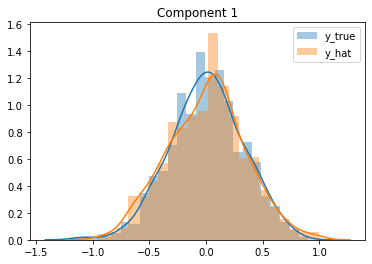

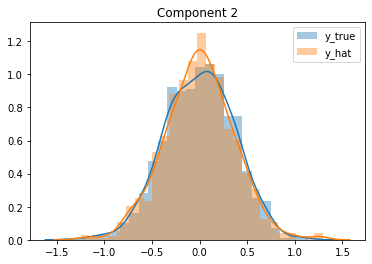

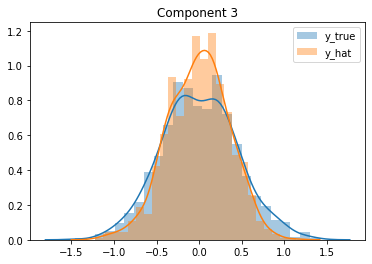

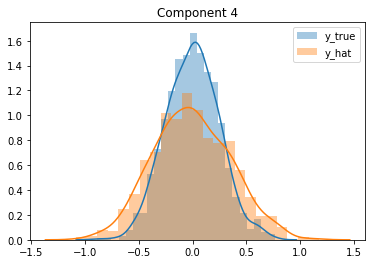

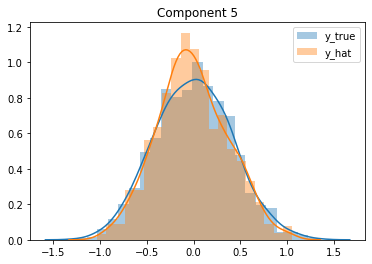

In [34]:
for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_hat[:,j], label='y_hat')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()
    

In [35]:
v_star_list

array([0.02279706, 0.03325836, 0.02826783, 0.04070575])

In [36]:
sigma2_star

0.04453815471624844

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.026  0.013   0.010    0.047      0.001    0.000     412.0   330.0   
v[1]    0.026  0.012   0.009    0.046      0.000    0.000     591.0   560.0   
v[2]    0.027  0.012   0.011    0.051      0.000    0.000     662.0   597.0   
v[3]    0.027  0.014   0.009    0.050      0.001    0.001     294.0   230.0   
sigma2  0.119  0.004   0.112    0.127      0.000    0.000     971.0   970.0   
W[0,0] -0.002  0.040  -0.073    0.074      0.001    0.001    1123.0  1123.0   
W[0,1] -0.000  0.059  -0.111    0.100      0.002    0.002     738.0   738.0   
W[0,2]  0.005  0.060  -0.098    0.117      0.002    0.002     620.0   620.0   
W[0,3] -0.004  0.072  -0.125    0.124      0.003    0.002     626.0   626.0   
W[0,4] -0.002  0.064  -0.108    0.122      0.003    0.002     544.0   544.0   
W[1,0]  0.001  0.043  -0.073    0.086      0.001    0.001     998.0   923.0   
W[1,1]  0.003  0.060  -0.110    0.103      0.002    

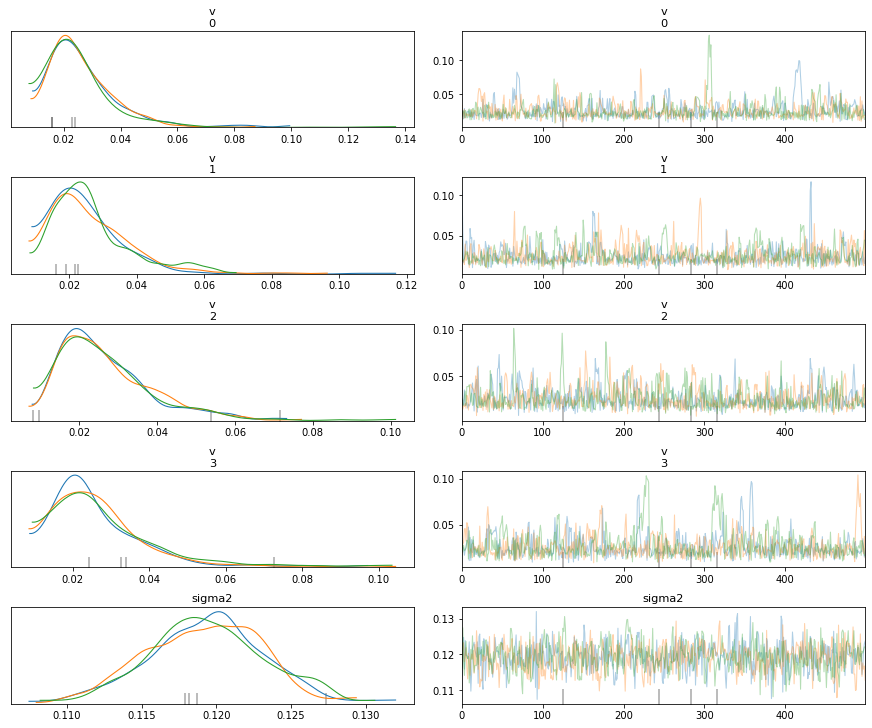

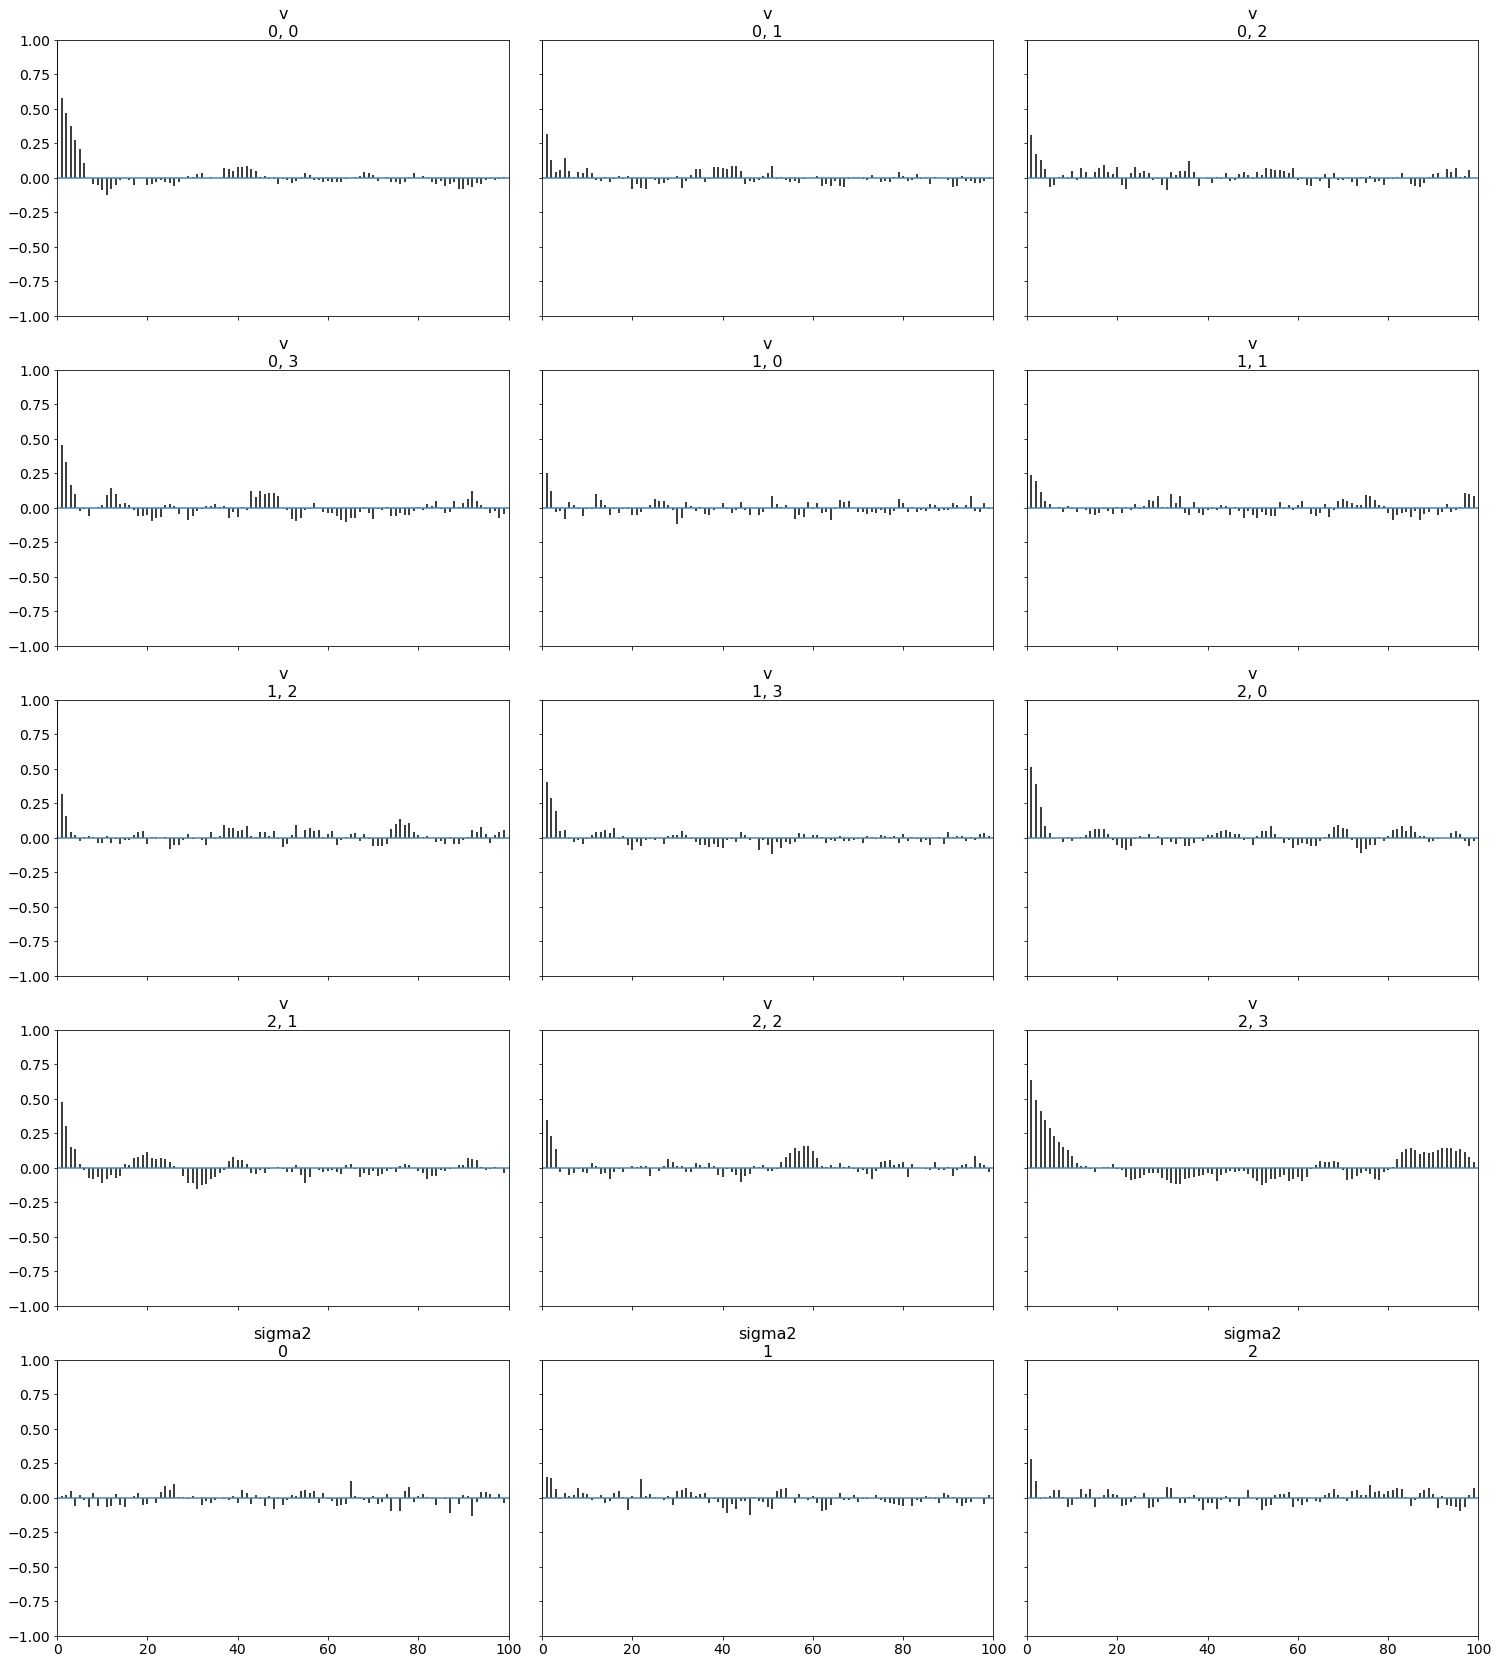

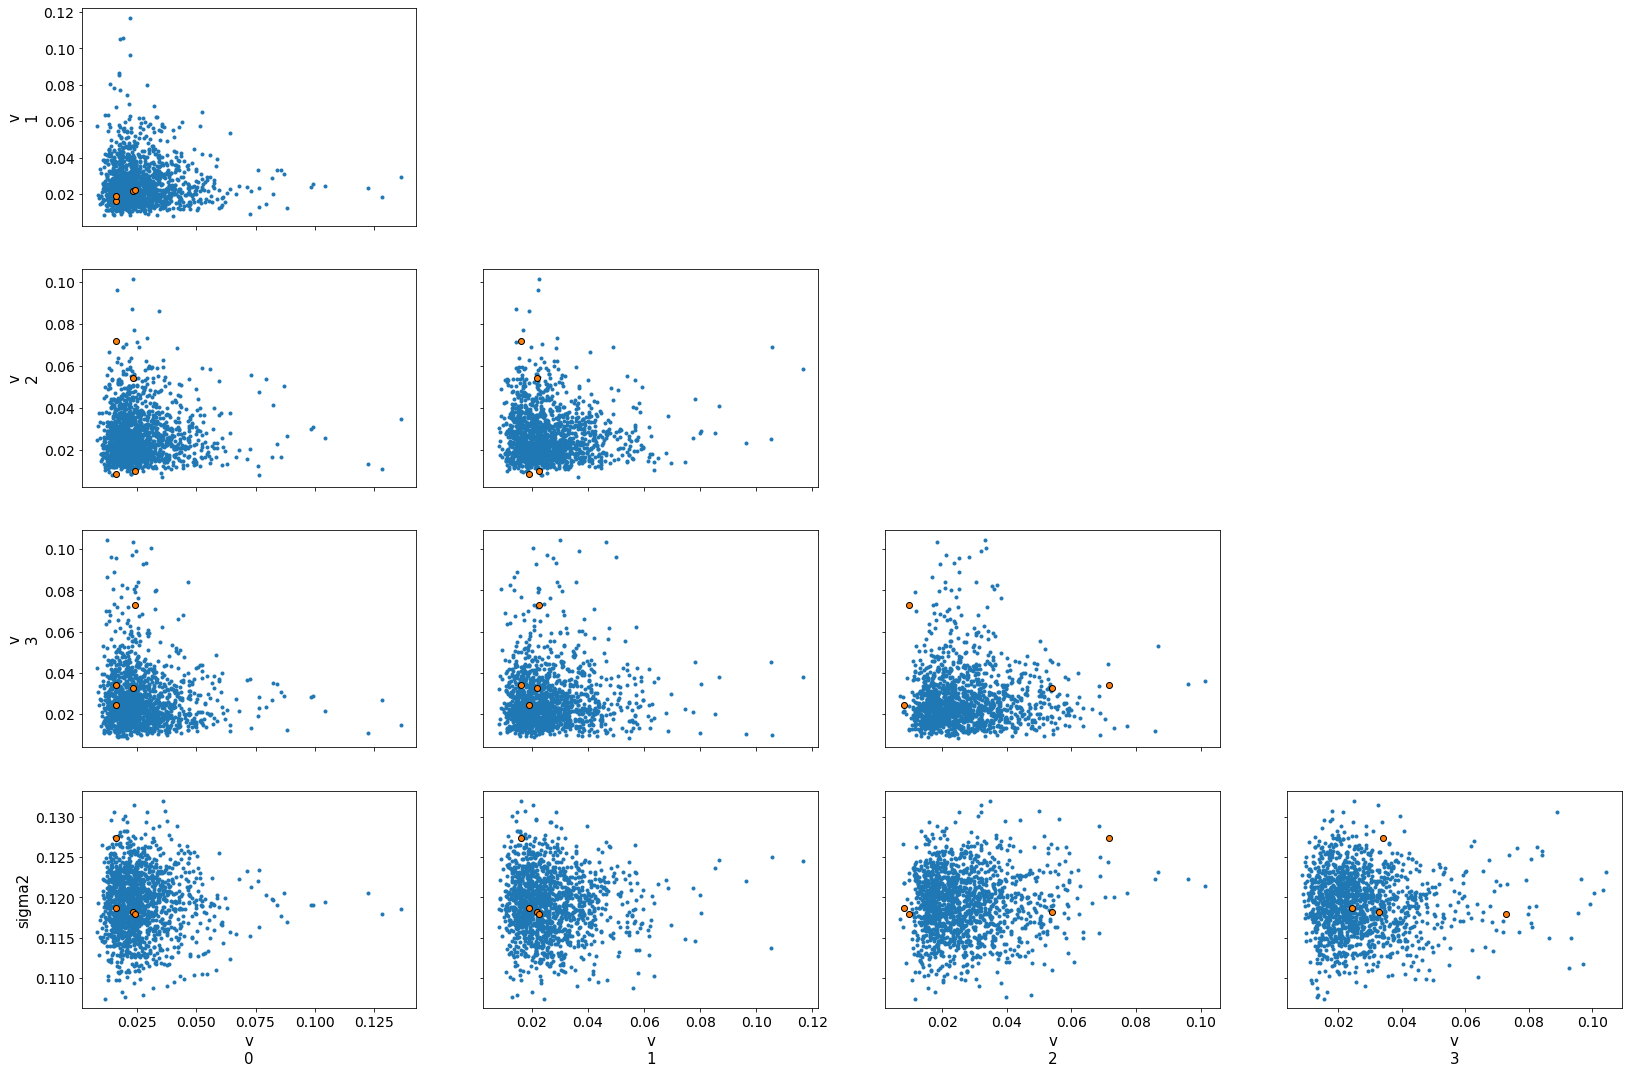

In [37]:
az_v_sigma2_plot(fit_standard)

## 4. MCMC Exact

In [38]:
ppca_dat_exact = ppca_dat_standard.copy()
ppca_dat_exact['xi']= xi

In [39]:
fit_exact = sm.sampling(data = ppca_dat_exact, iter = iterations, chains = n_chains, init = init_list,  seed =1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [40]:
v_star_list

array([0.02279706, 0.03325836, 0.02826783, 0.04070575])

In [41]:
sigma2_star

0.04453815471624844

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
v[0]    0.028  0.014   0.010    0.054      0.001    0.001     286.0   215.0   
v[1]    0.026  0.012   0.009    0.047      0.000    0.000     626.0   491.0   
v[2]    0.027  0.014   0.009    0.051      0.001    0.001     401.0   350.0   
v[3]    0.026  0.012   0.010    0.047      0.001    0.000     458.0   364.0   
sigma2  0.118  0.005   0.110    0.128      0.000    0.000    1186.0  1186.0   
W[0,0] -0.000  0.049  -0.089    0.089      0.001    0.001    1186.0  1085.0   
W[0,1]  0.005  0.061  -0.105    0.112      0.002    0.001    1002.0  1002.0   
W[0,2] -0.003  0.064  -0.121    0.108      0.002    0.002     792.0   792.0   
W[0,3]  0.003  0.072  -0.119    0.140      0.003    0.002     824.0   824.0   
W[0,4]  0.000  0.067  -0.121    0.114      0.002    0.002     848.0   848.0   
W[1,0]  0.000  0.048  -0.083    0.090      0.001    0.001    1081.0  1056.0   
W[1,1]  0.001  0.062  -0.113    0.109      0.002    

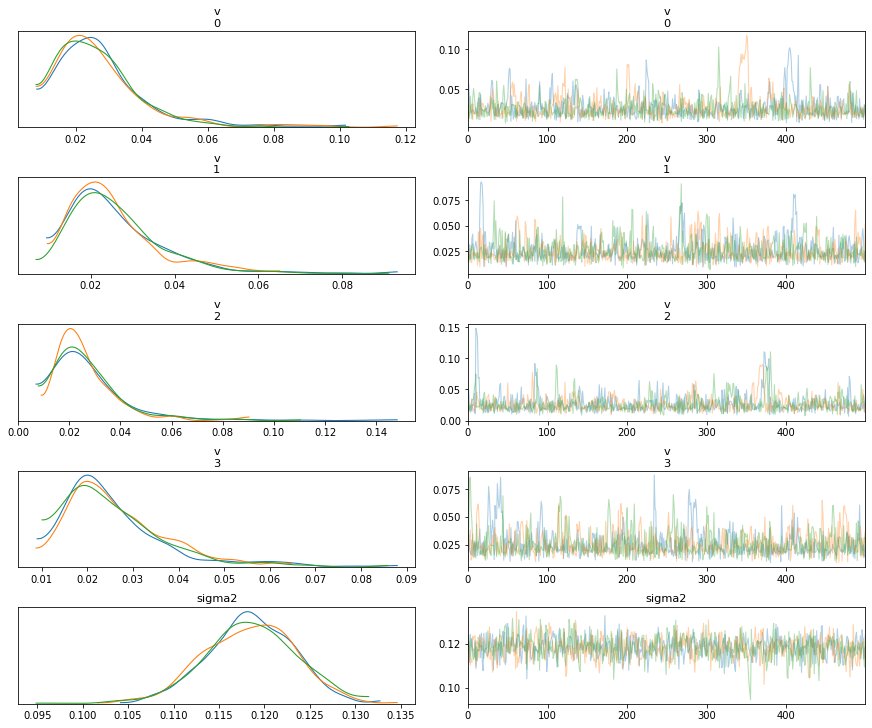

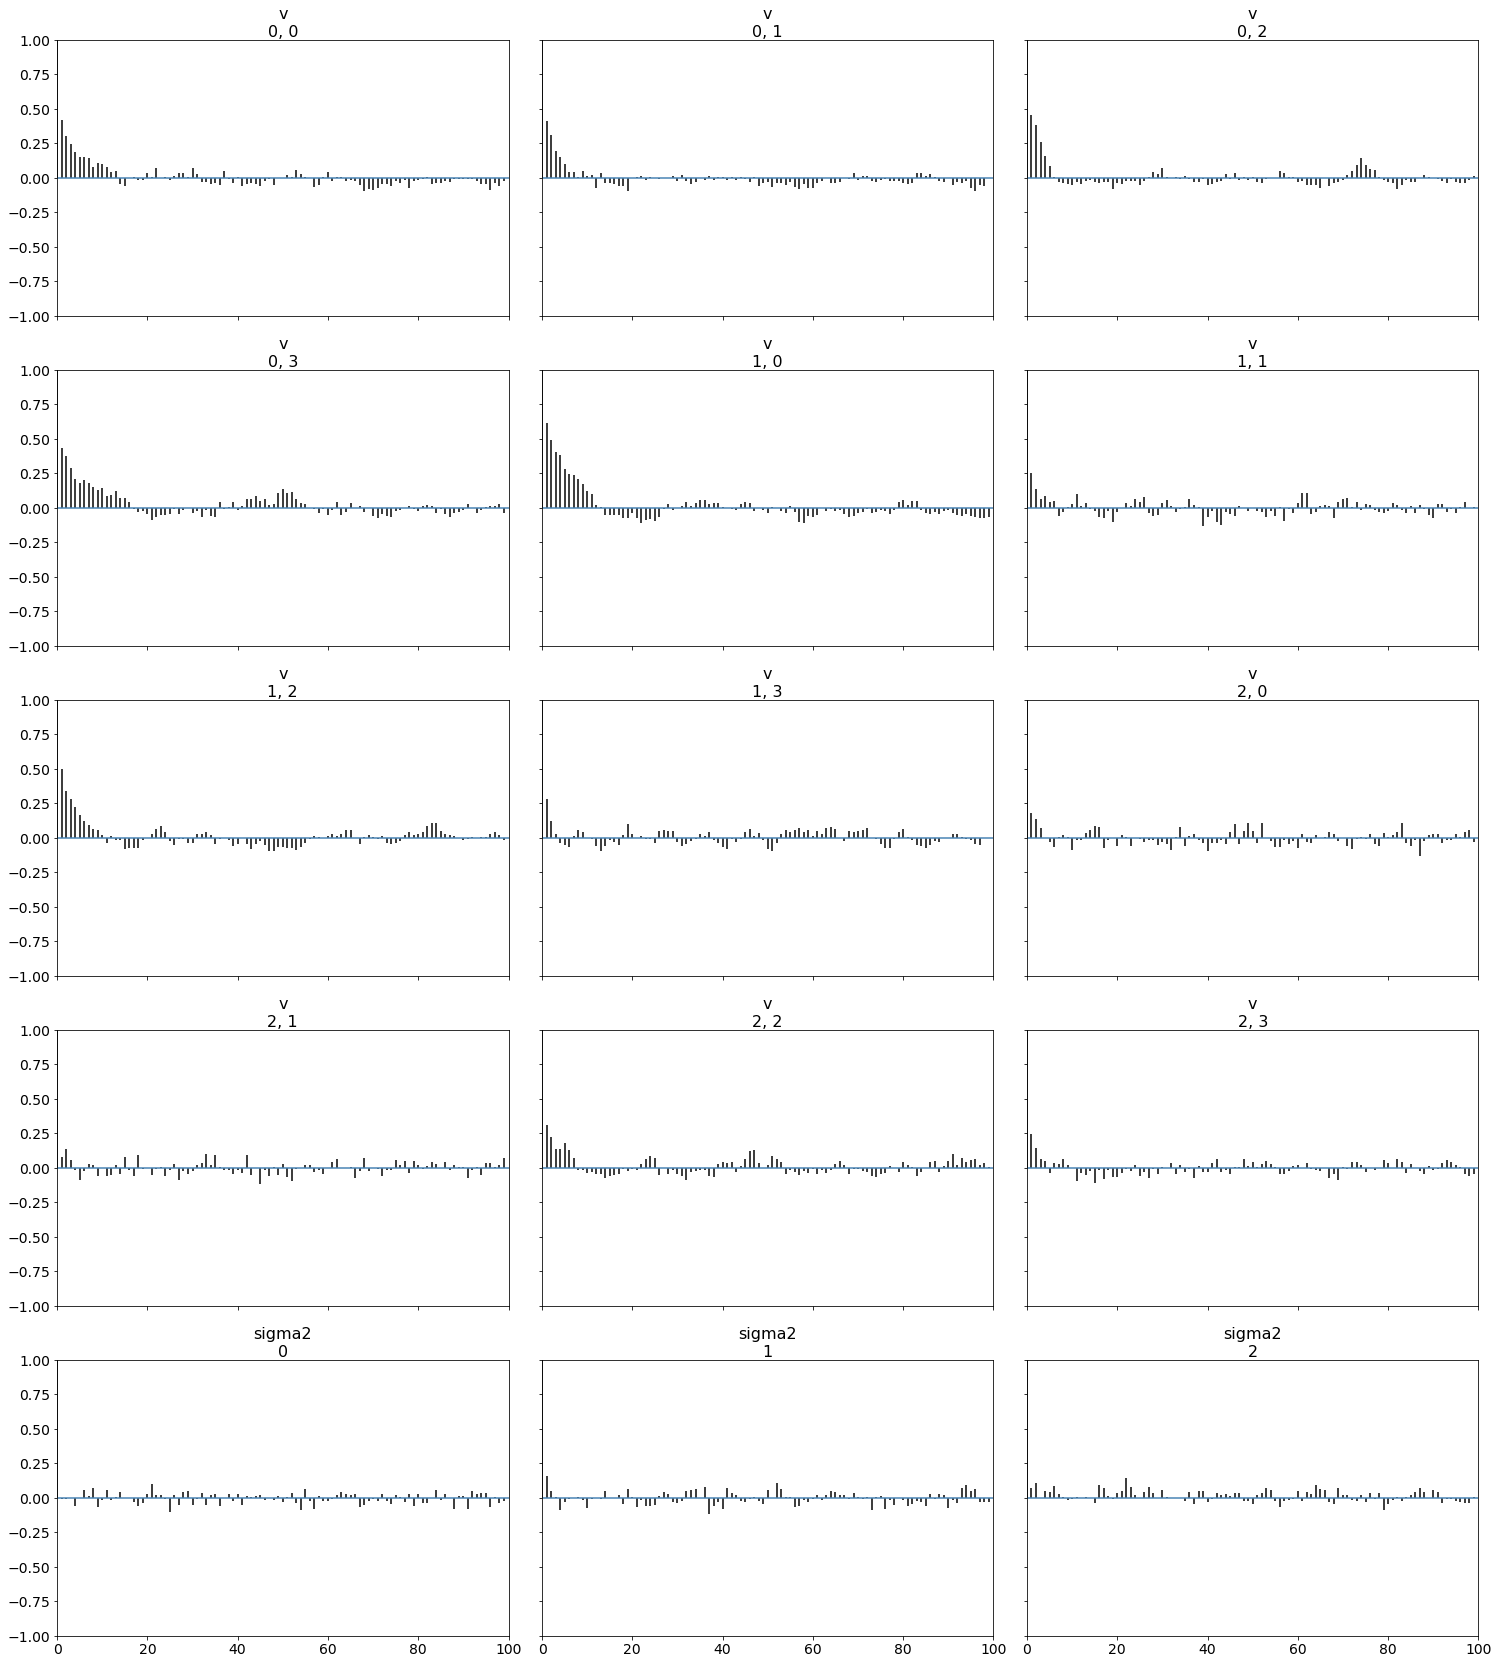

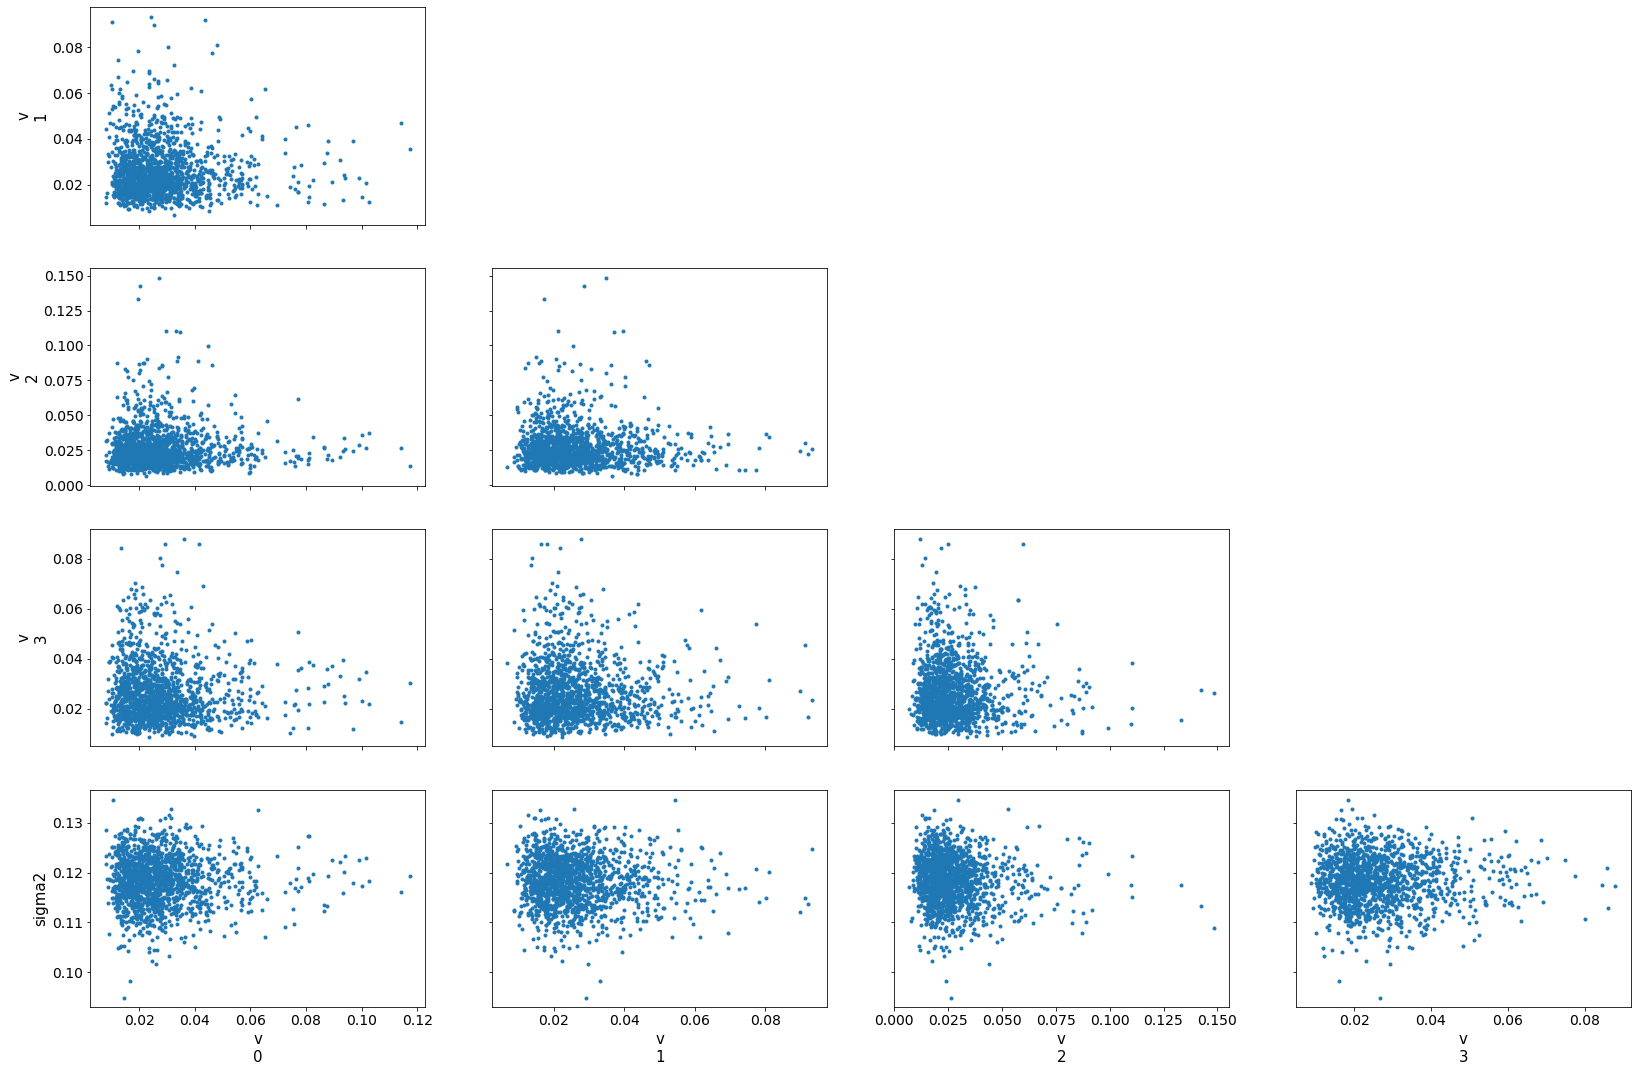

In [42]:
az_v_sigma2_plot(fit_exact)

In [43]:
print(mcmc_setup)

{'q': '4', 'xi': '0.5', 'iterations': '1000', 'n_chains': '3', 'a_sigma2': '3', 'beta_sigma2': '0.2', 'a_vj': '3.5', 'epsilon': '0.05'}


In [44]:
print(data_config)

{'d': '5', 'q_star': '4', 'n_sample': '1000', 'a_sigma2': '3', 'beta_sigma2': '0.2', 'alpha': '500', 'a_vj': '3.5', 'epsilon': '0.05'}
